In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [1]:
from datasets import load_dataset

dataset = load_dataset(
    'cifar10',
    # args.dataset_config_name,
    # cache_dir=args.cache_dir,
    # split="train",
)

NameError: name 'load_dataset' is not defined

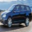

In [10]:
from datasets import DatasetDict, Dataset, load_dataset, Image

train_dataset = dataset['train'].select(idx_train)
train_dataset[0]["img"]

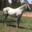

In [11]:
val_dataset =  dataset['test'].select(idx_val)
val_dataset[0]["img"]

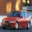

In [12]:
val_dataset[1]['img']

In [13]:
# idx_val[0:5]

In [16]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.15)

2728

In [17]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=2e3, eps=0.15)

3002

In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=5e3, eps=0.15)

3364

In [19]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e4, eps=0.15)

3638

In [20]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [21]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

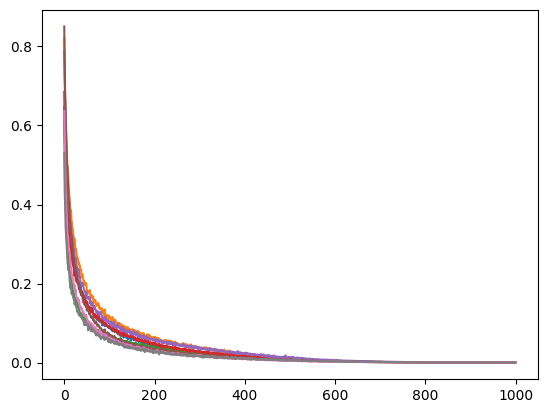

In [22]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [23]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [24]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

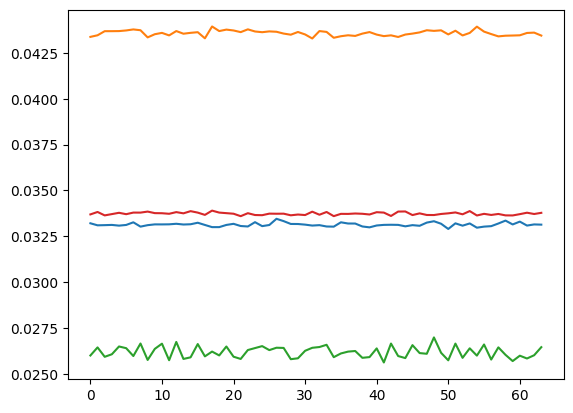

In [25]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [26]:
loss_array_list = []

for i in range(512):
    for seed in [
        0,
                 # 1,
                 # 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/retrain/ddpm-sub-{}-{}/e-{}-val.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3)
    
    loss_array_list.append(loss_array)
retrain_loss_array = np.stack(loss_array_list)
retrain_loss_array.shape

(512, 1000, 1000)

In [27]:
mask_array_list = []

for i in range(512):
    # print(i)
    with open('../../data/indices/5000-0.5/retrain/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
retrain_mask_array = np.stack(mask_array_list)
retrain_mask_array.shape

(512, 5000)

In [28]:
retrain_testset_correctness = retrain_loss_array.mean(axis=1)
retrain_testset_correctness.shape

(512, 1000)

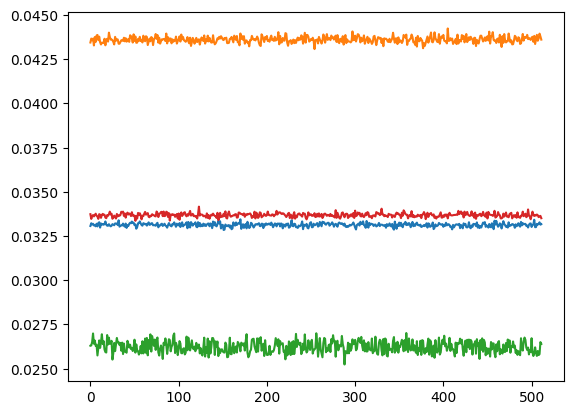

In [29]:
for j in range(4):
    plt.plot(retrain_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [30]:
retrain_mask_array.shape

(512, 5000)

In [31]:
retrain_testset_correctness.shape

(512, 1000)

In [32]:
emp_scores_list = []

In [33]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV

In [34]:
import time

In [35]:
if True:
    s = time.time()
    infl_est_ = []
    for i in range(1000):
        # print(i)
        reg = RidgeCV(cv=5, alphas=[0.1, 1.0, 1e1], 
                      # random_state=42, 
                      # n_jobs=-1
                     ).fit(
            retrain_mask_array[0:64], retrain_testset_correctness[0:64, i])
        infl_est_.append(reg.coef_)
        # break
    print(time.time()-s)
    
    infl_est_ = np.stack(infl_est_)
    print(infl_est_.shape)
    emp_scores_list.append(infl_est_)

    # compute lds
    from scipy.stats import spearmanr
    ####
    margins = lds_testset_correctness[:]
    preds = lds_mask_array[:] @ infl_est_.T
    ####
    rs = []
    ps = []
    
    for ind in range(1000):
        r, p = spearmanr(preds[:, ind], margins[:, ind])
        rs.append(r)
        ps.append(p)
        
    rs, ps = np.array(rs), np.array(ps)
    
    print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

277.86273431777954
(1000, 5000)
Correlation: 0.06042137480355201 (avg p value 0.464607)
Correlation: 0.060 (avg p value 0.464607)
Correlation: 0.0604 (avg p value 0.464607)
Correlation: 0.06042 (avg p value 0.464607)


In [36]:
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')

Correlation: 0.0604 (avg p value 0.464607)


In [37]:
if True:
    s = time.time()
    infl_est_ = []
    for i in range(1000):
        # print(i)
        reg = RidgeCV(cv=5, alphas=[0.1, 1.0, 1e1], 
                      # random_state=42, 
                      # n_jobs=-1
                     ).fit(
            retrain_mask_array[0:128], retrain_testset_correctness[0:128, i])
        infl_est_.append(reg.coef_)
        # break
    print(time.time()-s)
    
    infl_est_ = np.stack(infl_est_)
    print(infl_est_.shape)
    emp_scores_list.append(infl_est_)

    # compute lds
    from scipy.stats import spearmanr
    ####
    margins = lds_testset_correctness[:]
    preds = lds_mask_array[:] @ infl_est_.T
    ####
    rs = []
    ps = []
    
    for ind in range(1000):
        r, p = spearmanr(preds[:, ind], margins[:, ind])
        rs.append(r)
        ps.append(p)
        
    rs, ps = np.array(rs), np.array(ps)
    
    print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

513.2369022369385
(1000, 5000)
Correlation: 0.09013978661785575 (avg p value 0.420151)
Correlation: 0.090 (avg p value 0.420151)
Correlation: 0.0901 (avg p value 0.420151)
Correlation: 0.09014 (avg p value 0.420151)


In [38]:
print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')

Correlation: 0.0901 (avg p value 0.420151)


In [54]:
# if True:
#     s = time.time()
#     infl_est_ = []
#     for i in range(1000):
#         # print(i)
#         reg = RidgeCV(cv=5, alphas=[0.1, 1.0, 1e1], 
#                       # random_state=42, 
#                       # n_jobs=-1
#                      ).fit(
#             retrain_mask_array[0:192], retrain_testset_correctness[0:192, i])
#         infl_est_.append(reg.coef_)
#         # break
#     print(time.time()-s)
    
#     infl_est_ = np.stack(infl_est_)

#     # compute lds
#     from scipy.stats import spearmanr
#     ####
#     margins = lds_testset_correctness[:]
#     preds = lds_mask_array[:] @ infl_est_.T
#     ####
#     rs = []
#     ps = []
    
#     for ind in range(1000):
#         r, p = spearmanr(preds[:, ind], margins[:, ind])
#         rs.append(r)
#         ps.append(p)
        
#     rs, ps = np.array(rs), np.array(ps)
    
#     print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
#     print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
#     print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
#     print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

329.75700426101685
Correlation: 0.10950762215866783 (avg p value 0.393747)
Correlation: 0.110 (avg p value 0.393747)
Correlation: 0.1095 (avg p value 0.393747)
Correlation: 0.10951 (avg p value 0.393747)


In [39]:
if True:
    s = time.time()
    infl_est_ = []
    for i in range(1000):
        # print(i)
        reg = RidgeCV(cv=5, alphas=[0.1, 1.0, 1e1], 
                      # random_state=42, 
                      # n_jobs=-1
                     ).fit(
            retrain_mask_array[0:256], retrain_testset_correctness[0:256, i])
        infl_est_.append(reg.coef_)
        # break
    print(time.time()-s)
    
    infl_est_ = np.stack(infl_est_)
    print(infl_est_.shape)
    emp_scores_list.append(infl_est_)

    # compute lds
    from scipy.stats import spearmanr
    ####
    margins = lds_testset_correctness[:]
    preds = lds_mask_array[:] @ infl_est_.T
    ####
    rs = []
    ps = []
    
    for ind in range(1000):
        r, p = spearmanr(preds[:, ind], margins[:, ind])
        rs.append(r)
        ps.append(p)
        
    rs, ps = np.array(rs), np.array(ps)
    
    print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

818.3052246570587
(1000, 5000)
Correlation: 0.12500657177690028 (avg p value 0.363419)
Correlation: 0.125 (avg p value 0.363419)
Correlation: 0.1250 (avg p value 0.363419)
Correlation: 0.12501 (avg p value 0.363419)


In [40]:
if True:
    s = time.time()
    infl_est_ = []
    for i in range(1000):
        # print(i)
        reg = RidgeCV(cv=5, alphas=[0.1, 1.0, 1e1], 
                      # random_state=42, 
                      # n_jobs=-1
                     ).fit(
            retrain_mask_array[0:512], retrain_testset_correctness[0:512, i])
        infl_est_.append(reg.coef_)
        # break
    print(time.time()-s)
    
    infl_est_ = np.stack(infl_est_)
    print(infl_est_.shape)
    emp_scores_list.append(infl_est_)

    # compute lds
    from scipy.stats import spearmanr
    ####
    margins = lds_testset_correctness[:]
    preds = lds_mask_array[:] @ infl_est_.T
    ####
    rs = []
    ps = []
    
    for ind in range(1000):
        r, p = spearmanr(preds[:, ind], margins[:, ind])
        rs.append(r)
        ps.append(p)
        
    rs, ps = np.array(rs), np.array(ps)
    
    print(f'Correlation: {rs.mean()} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.4f} (avg p value {ps.mean():.6f})')
    print(f'Correlation: {rs.mean():.5f} (avg p value {ps.mean():.6f})')

2523.149385213852
(1000, 5000)
Correlation: 0.1725912670674225 (avg p value 0.271854)
Correlation: 0.173 (avg p value 0.271854)
Correlation: 0.1726 (avg p value 0.271854)
Correlation: 0.17259 (avg p value 0.271854)


In [41]:
with open('./val_emp.pkl', 'wb') as handle:
    pickle.dump(emp_scores_list, handle)